In [1]:
import torch
import torch.nn.functional as F
from benchmark import models
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import matplotlib.pyplot as plt
import numpy as np
import re
import logging
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.ticker as ticker

In [2]:
sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.set_palette("colorblind")

In [3]:
def load_best_model(model_cls, weights, version):
    """
    Determines the model with lowest validation loss from the csv logs and loads it

    :param model_cls: Class of the lightning module to load
    :param weights: Path to weights as in cmd arguments
    :param version: String of version file
    :return: Instance of lightning module that was loaded from the best checkpoint
    """
    metrics = pd.read_csv(weights / version / "metrics.csv")

    idx = np.nanargmin(metrics["val_loss"])
    min_row = metrics.iloc[idx]

    checkpoint = f"epoch={min_row['epoch']:.0f}-step={min_row['step']:.0f}.ckpt"

    version_id = version.split("_")[-1]
    version_str = f"{version_id}_{version_id}"

    checkpoint_path = (
        weights.parent
        / f"{weights.name}_{weights.name}"
        / version_str
        / "checkpoints"
        / checkpoint
    )

    return model_cls.load_from_checkpoint(checkpoint_path)

In [4]:
# Load data

target = "ethz"

data_kwargs = dict(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")

data = sbd.ETHZ(**data_kwargs)

data = data.dev()  # Intepretation on dev set

2021-07-27 13:57:30,753 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
<ipython-input-4-3ca4ed16c22c>:7: DtypeWarning: Columns (53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  data = sbd.ETHZ(**data_kwargs)


In [5]:
# Load models
basepath = Path("weights")

basicphaseae = load_best_model(models.BasicPhaseAELit, basepath / f"{target}_basicphaseae", "version_0")
cred = load_best_model(models.CREDLit, basepath / f"{target}_cred", "version_0")
eqtransformer = load_best_model(models.EQTransformerLit, basepath / f"{target}_eqtransformer", "version_0")
gpd = load_best_model(models.GPDLit, basepath / f"{target}_gpd", "version_0")
phasenet = load_best_model(models.PhaseNetLit, basepath / f"{target}_phasenet", "version_0")

In [6]:
# Load targets and create generators
targetpath = Path("targets") / target / "task1.csv"

task_targets = pd.read_csv(targetpath)
task_targets = task_targets[task_targets["trace_split"] == "dev"]

basicphaseae_generator = sbg.SteeredGenerator(data, task_targets)
basicphaseae_generator.add_augmentations(basicphaseae.get_eval_augmentations())
cred_generator = sbg.SteeredGenerator(data, task_targets)
cred_generator.add_augmentations(cred.get_eval_augmentations())
eqtransformer_generator = sbg.SteeredGenerator(data, task_targets)
eqtransformer_generator.add_augmentations(eqtransformer.get_eval_augmentations())
gpd_generator = sbg.SteeredGenerator(data, task_targets)
gpd_generator.add_augmentations(gpd.get_eval_augmentations())
phasenet_generator = sbg.SteeredGenerator(data, task_targets)
phasenet_generator.add_augmentations(phasenet.get_eval_augmentations())

In [7]:
color_dict = {"det": "C0", "P": "C1", "S": "C2"}

In [8]:
def basicphaseae_plot(idx, ax):
    batch = basicphaseae_generator[idx]
    x = torch.tensor(batch["X"]).unsqueeze(0)
    p0, p1 = batch["window_borders"]
    
    re = torch.zeros(x.shape[:2] + (7, 600), dtype=x.dtype)
    for i, start in enumerate(range(0, 2401, 400)):
        re[:, :, i] = x[:, :, start:start + 600]
    
    x = re
    x = x.permute(0, 2, 1, 3)  # --> (batch, windows, channels, samples)
    shape_save = x.shape
    x = x.reshape(-1, 3, 600)  # --> (batch * windows, channels, samples)
    pred = basicphaseae(x)
    pred = pred.reshape(
        shape_save[:2] + (3, 600)
    )  # --> (batch, window, channels, samples)
    full_pred = torch.zeros((pred.shape[0], pred.shape[2], 3000))
    for i, start in enumerate(range(0, 2401, 400)):
        if start == 0:
            # Use full window (for start==0, the end will be overwritten)
            full_pred[:, :, start:start + 600] = pred[:, i]
        else:
            full_pred[:, :, start + 100:start + 600] = pred[:, i, :, 100:]
        
    
    # ax.plot(1 - pred[0, 2, p0:p1])
    ax.plot(full_pred[0, 0, p0:p1], color_dict["P"])
    ax.plot(full_pred[0, 1, p0:p1], color_dict["S"])

In [9]:
def cred_plot(idx, ax):
    batch = cred_generator[idx]
    x = torch.tensor(batch["spec"]).unsqueeze(0)
    p0, p1 = batch["window_borders"]
    
    samples = p1 - p0

    pred = cred(x)
    p0 = p0 // 158
    p1 = p1 // 158 + 1
    pred = pred[0, p0:p1, 0]
    ax.plot(np.linspace(0, samples, pred.shape[0]), pred, color_dict["det"])

In [10]:
def eqtransformer_plot(idx, ax):
    batch = eqtransformer_generator[idx]
    p0, p1 = batch["window_borders"]
    det_pred, p_pred, s_pred = eqtransformer(torch.tensor(batch["X"]).unsqueeze(0))
    ax.plot(det_pred[0, p0:p1], color_dict["det"])
    ax.plot(p_pred[0, p0:p1], color_dict["P"])
    ax.plot(s_pred[0, p0:p1], color_dict["S"])

In [11]:
def gpd_plot(idx, ax):
    batch = gpd_generator[idx]
    x = torch.tensor(batch["X"]).unsqueeze(0)
    p0, p1 = batch["window_borders"]

    shape_save = x.shape
    x = x.reshape(
        (-1,) + shape_save[2:]
    )  # Merge batch and sliding window dimensions
    pred = gpd(x)
    pred = pred.reshape(shape_save[:2] + (-1,))
    pred = torch.repeat_interleave(
        pred, gpd.predict_stride, dim=1
    )  # Counteract stride
    pred = F.pad(pred, (0, 0, 200, 200))
    pred = pred.permute(0, 2, 1)
    
    # ax.plot(1 - pred[0, 2, p0:p1])
    ax.plot(pred[0, 0, p0:p1], color_dict["P"])
    ax.plot(pred[0, 1, p0:p1], color_dict["S"])

In [12]:
def phasenet_plot(idx, ax):
    batch = phasenet_generator[idx]
    x = torch.tensor(batch["X"]).unsqueeze(0)
    p0, p1 = batch["window_borders"]

    pred = phasenet(x)
    # ax.plot(1 - pred[0, 2, p0:p1])
    ax.plot(pred[0, 0, p0:p1], color_dict["P"])
    ax.plot(pred[0, 1, p0:p1], color_dict["S"])

In [13]:
def annotations_plot(idx, ax):    
    row = task_targets.iloc[idx]
    data_idx = data.get_idx_from_trace_name(row["trace_name"])
    _, metadata = data.get_sample(data_idx)
    
    ax.text(0.01, 0.98, row["trace_type"], va="top", ha="left", transform=ax.transAxes)
    
    for col, phase in models.phase_dict.items():
        if col not in metadata:
            continue
        if np.isnan(metadata[col]):
            continue
        
        ax.axvline(metadata[col] - row["start_sample"], c=color_dict[phase])

In [14]:
@ticker.FuncFormatter
def time_formatter(x, pos):
    return f"{x/100:.1f}"

Text(0, 0.5, 'PN')

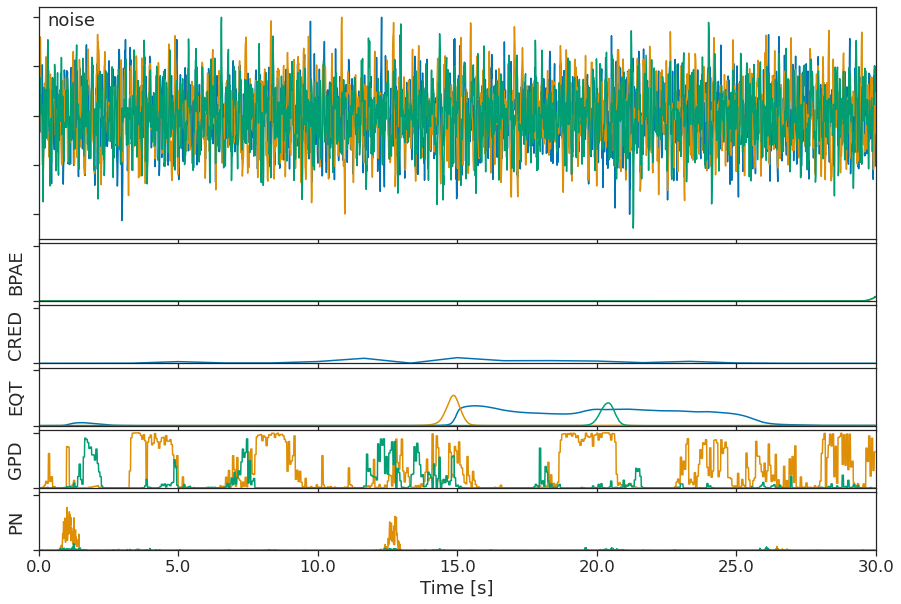

In [24]:
# idx = 0
idx = np.random.randint(len(task_targets))

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(6, 1, sharex=True, gridspec_kw={"hspace": 0.05, "height_ratios": [4, 1, 1, 1, 1, 1]})

for ax in axs:
    ax.set_yticklabels([])
    
for ax in axs[1:]:
    ax.set_ylim(0, 1.05)
    
batch = eqtransformer_generator[idx]
waveforms = batch["X"]
p0, p1 = batch["window_borders"]
waveforms = waveforms[:, p0:p1]
axs[0].plot(waveforms.T)

annotations_plot(idx, axs[0])
with torch.no_grad():
    basicphaseae_plot(idx, axs[1])
    cred_plot(idx, axs[2])
    eqtransformer_plot(idx, axs[3])
    gpd_plot(idx, axs[4])
    phasenet_plot(idx, axs[5])
    
axs[0].set_xlim(0, waveforms.shape[1])
axs[-1].set_xlabel("Time [s]")
axs[0].xaxis.set_major_formatter(time_formatter)
axs[1].set_ylabel("BPAE")
axs[2].set_ylabel("CRED")
axs[3].set_ylabel("EQT")
axs[4].set_ylabel("GPD")
axs[5].set_ylabel("PN")